# Monitoring Notebook

## Loading necessary artifacts:

In [1]:
from stock_market_analytics.monitoring.monitoring_steps import (
    download_artifacts,
    load_model,
    load_reference_data,
)


model_dir, model_name, dataset_dir, dataset_name = download_artifacts()

model = load_model(model_dir, model_name)

reference_data = load_reference_data(dataset_dir, dataset_name)

wandb: Currently logged in as: san-cbtm to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb:   1 of 1 files downloaded.  
wandb: Downloading large artifact 'test_set:v0', 50.01MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:00.3 (145.0MB/s)


In [2]:
model

,steps,"[('transformations', ...), ('model', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('scalers', ...), ('reducers', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('financial_features_scaler', ...), ('liquidity_features_scaler', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3


In [3]:
reference_data

,symbol,month,day_of_week,day_of_year,log_returns_d,log_returns_ratio,rsi_ewm,sortino_ratio,sharpe_ratio_proxy,amihud_illiq,...,bull_strength,bear_strength,tenkan_kijun_spread_atr,price_above_cloud_atr,price_below_cloud_atr,cloud_thickness_atr,price_vs_lead_top_atr,price_vs_lead_bot_atr,atr,y_log_returns
1760,A,2,1,48,0.000000,-0.006119,15.993602,-0.624906,-9.058732,4.056669e-11,...,-0.000000,0.129528,-0.129528,-2.619774,2.064762,0.555012,-4.230498,-3.228409,3.574864,0.005184
1761,A,2,2,49,0.003928,-0.018729,20.368387,-0.511138,-7.214354,3.618766e-11,...,0.000000,0.000000,0.000000,-2.619834,1.949048,0.670785,-4.418897,-3.334332,3.303015,0.001256
1762,A,2,3,50,0.014320,-0.029485,34.180273,-0.598634,-10.031011,3.641593e-11,...,-0.000000,0.559594,-0.559594,-2.130886,1.147645,0.983241,-4.079984,-3.156806,3.149665,-0.013728
1763,A,2,4,51,-0.002628,-0.023045,33.018463,-0.626544,-10.476759,3.572885e-11,...,-0.000000,0.862410,-0.862410,-2.359589,1.188937,1.170652,-4.408441,-4.230639,2.996314,-0.019265
1764,A,2,5,52,-0.010435,-0.022238,28.732830,-0.698533,-11.556203,3.942963e-11,...,-0.000000,1.620475,-1.620475,-2.879352,1.317173,1.562179,-4.950991,-4.782017,2.946526,-0.006671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710019,ZTS,8,3,239,0.003740,0.016086,58.149101,0.647564,5.651265,1.651380e-11,...,0.000000,-0.000000,0.480977,-0.000001,-0.716078,0.716080,1.155776,1.155776,2.786002,0.006607
1710020,ZTS,8,4,240,-0.003740,0.033757,54.771460,0.699069,6.002274,1.507341e-11,...,0.000000,-0.000000,0.251879,-0.515038,-0.531952,1.046990,0.992477,0.992477,2.660002,-0.012416
1710021,ZTS,8,5,241,0.010347,0.008200,61.593301,0.845918,7.123268,1.725837e-11,...,0.000000,-0.000000,0.329560,-0.024377,-1.179793,1.204171,1.657561,1.657561,2.564003,-0.025711
1710022,ZTS,8,6,242,0.000000,0.053238,61.593291,0.845918,7.123268,1.646028e-11,...,0.045159,-0.000000,0.045159,0.132256,-1.068813,0.936557,1.827951,2.360208,2.325003,-0.020673


## Monitoring Checks:

In [4]:
# Import monitoring functions and load current data
from stock_market_analytics.monitoring.monitoring_steps import (
    load_monitoring_df,
    get_covariate_drift_metrics,
    get_prediction_drift_metrics, 
    get_predicted_quantiles_metrics,
    get_calibration_metrics,
    plot_drift_metrics,
    plot_performance_metrics,
    generate_monitoring_report
)
from stock_market_analytics.config import config
import pandas as pd
import numpy as np

In [5]:
# Load current monitoring data (last time_span days of labeled data)
# Set the BASE_DATA_PATH environment variable to point to your data directory
import os
base_path = os.environ["BASE_DATA_PATH"]

### 1. Data Preparation and Feature Alignment

In [6]:
# Load current production data (has dates)
current_data = load_monitoring_df(base_path)  # Update path as needed
print(f"Current production data shape: {current_data.shape}")
print(f"Current data date range: {current_data['date'].min()} to {current_data['date'].max()}")

# Reference data (test set) - no dates, just features and target
print(f"Reference data (test set) shape: {reference_data.shape}")

# Get feature columns from config
feature_columns = config.modeling.features
print(f"\nFeature columns from config: {len(feature_columns)}")
print(f"Target variable: {config.modeling.target}")
print(f"Quantiles: {config.modeling.quantiles}")

# Check feature availability in both datasets
ref_features = set(reference_data.columns)
curr_features = set(current_data.columns)
config_features = set(feature_columns)

print(f"\nFeatures in reference data: {len(ref_features)}")
print(f"Features in current data: {len(curr_features)}")
print(f"Features in config: {len(config_features)}")
print(f"Common features for drift analysis: {len(config_features & ref_features & curr_features)}")

Current production data shape: (179230, 56)
Current data date range: 2025-02-16 00:00:00 to 2025-08-31 00:00:00
Reference data (test set) shape: (178325, 49)

Feature columns from config: 48
Target variable: y_log_returns
Quantiles: [0.1, 0.25, 0.5, 0.75, 0.9]

Features in reference data: 49
Features in current data: 56
Features in config: 48
Common features for drift analysis: 48


### 2. Covariate Drift Detection

In [7]:
# Perform covariate drift detection
drift_features = list(config_features & ref_features & curr_features)
print(f"Analyzing drift for {len(drift_features)} features...")

covariate_drift_results = get_covariate_drift_metrics(
    reference_df=reference_data,
    current_df=current_data,
    feature_columns=drift_features
)

# Display summary results
print(f"\n=== COVARIATE DRIFT SUMMARY ===")
agg_metrics = covariate_drift_results["aggregate"]
print(f"Mean PSI: {agg_metrics['mean_psi']:.4f}")
print(f"Max PSI: {agg_metrics['max_psi']:.4f}")
print(f"Features with major drift (PSI > 0.2): {agg_metrics['fraction_drifted_features_psi']:.1%}")
print(f"Features with significant KS test (p < 0.05): {agg_metrics['fraction_significant_ks']:.1%}")

# Show top 5 features with highest drift
per_feature = covariate_drift_results["per_feature"]
sorted_features = sorted(per_feature.items(), key=lambda x: x[1]['psi'], reverse=True)

print(f"\n=== TOP 5 FEATURES WITH HIGHEST PSI ===")
for i, (feature, metrics) in enumerate(sorted_features[:5]):
    print(f"{i+1}. {feature}: PSI={metrics['psi']:.4f} ({metrics['psi_interpretation']}) | KS p-val={metrics['ks_p_value']:.4f}")

Analyzing drift for 48 features...

=== COVARIATE DRIFT SUMMARY ===
Mean PSI: 0.0000
Max PSI: 0.0004
Features with major drift (PSI > 0.2): 0.0%
Features with significant KS test (p < 0.05): 4.3%

=== TOP 5 FEATURES WITH HIGHEST PSI ===
1. month: PSI=0.0004 (no_drift) | KS p-val=0.0358
2. day_of_year: PSI=0.0002 (no_drift) | KS p-val=0.0209
3. day_of_week: PSI=0.0002 (no_drift) | KS p-val=0.0701
4. log_returns_d: PSI=0.0000 (no_drift) | KS p-val=0.9295
5. tenkan_kijun_spread_atr: PSI=0.0000 (no_drift) | KS p-val=1.0000


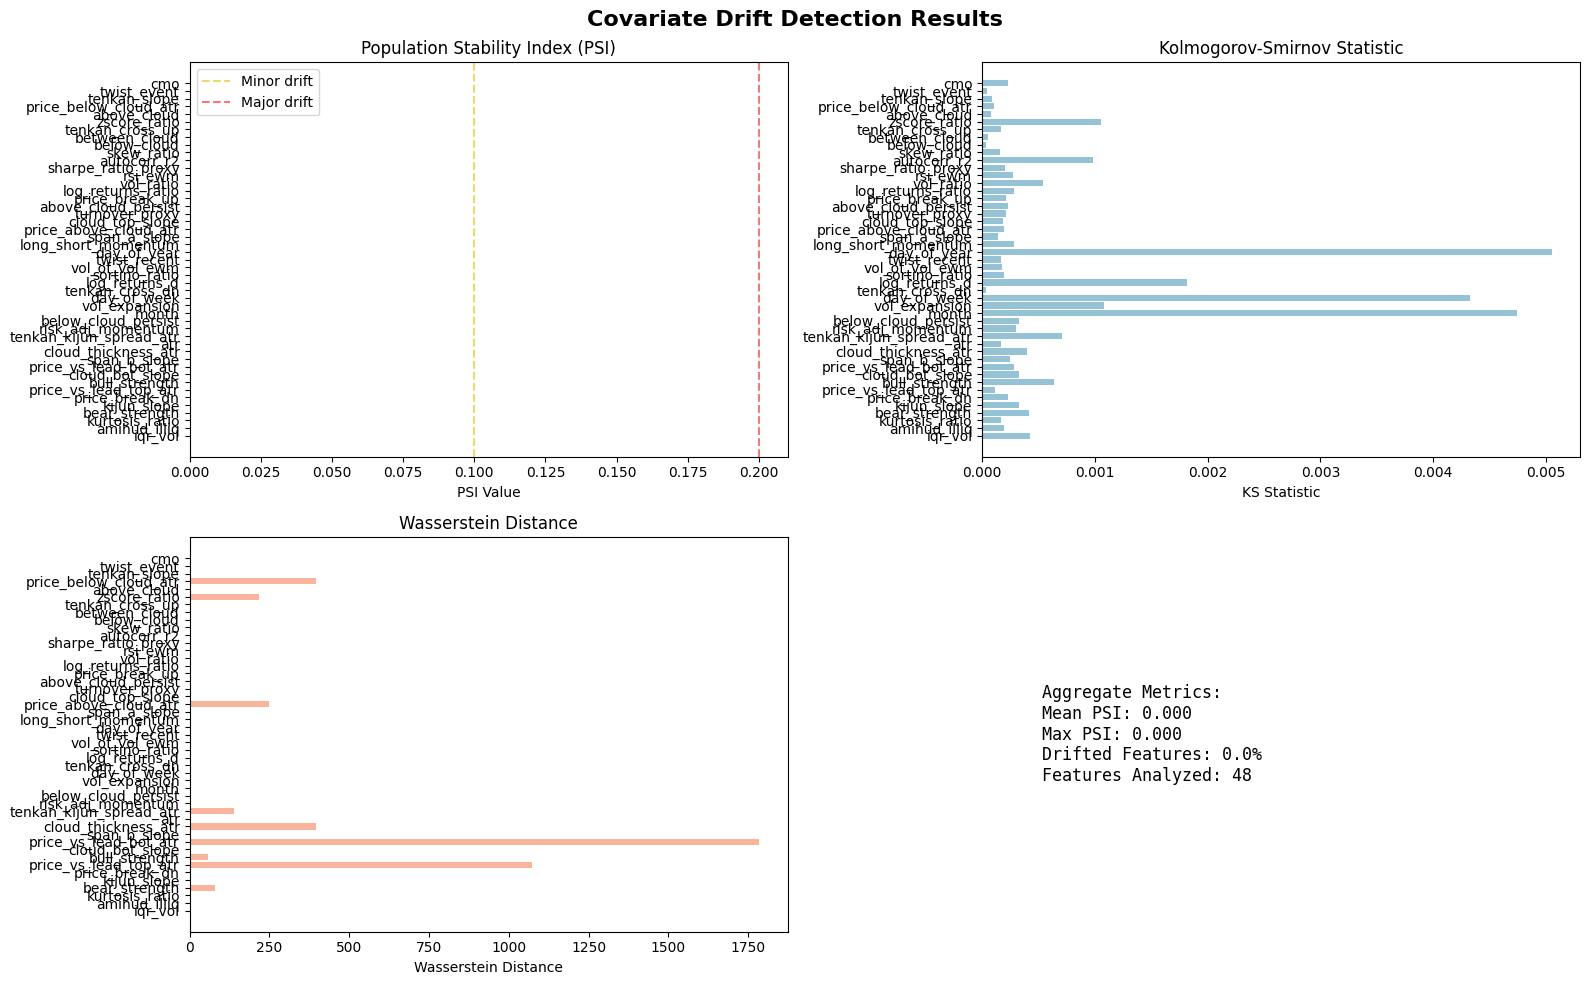

In [8]:
# Visualize covariate drift results
plot_drift_metrics(covariate_drift_results, figsize=(16, 10))

### 3. Target Distribution Drift

In [9]:
# Check target drift between reference and current data
from stock_market_analytics.monitoring.monitoring_steps import get_target_drift_metrics

target_col = config.modeling.target
target_drift_results = get_target_drift_metrics(
    reference_targets=reference_data[target_col],
    current_targets=current_data[target_col]
)

print(f"=== TARGET DRIFT ANALYSIS ({target_col}) ===")
dist_tests = target_drift_results["distribution_tests"]
print(f"PSI: {dist_tests['psi']:.4f} ({dist_tests['psi_interpretation']})")
print(f"KS test: statistic={dist_tests['ks_statistic']:.4f}, p-value={dist_tests['ks_p_value']:.4f}")

moments = target_drift_results["moments_comparison"]
print(f"\nMean shift: {moments['mean_shift']:.6f}")
print(f"Std ratio: {moments['std_ratio']:.4f}")
print(f"Reference mean: {moments['ref_mean']:.6f}, Current mean: {moments['curr_mean']:.6f}")
print(f"Reference std: {moments['ref_std']:.6f}, Current std: {moments['curr_std']:.6f}")

stat_tests = target_drift_results["statistical_tests"]
print(f"\nMean difference t-test p-value: {stat_tests['mean_diff_p_value']:.4f}")
print(f"Variance difference (Levene) p-value: {stat_tests['variance_levene_p_value']:.4f}")

=== TARGET DRIFT ANALYSIS (y_log_returns) ===
PSI: 0.0000 (no_drift)
KS test: statistic=0.0010, p-value=1.0000

Mean shift: -0.000090
Std ratio: 1.0013
Reference mean: 0.001907, Current mean: 0.001817
Reference std: 0.046531, Current std: 0.046591

Mean difference t-test p-value: 0.5619
Variance difference (Levene) p-value: 0.7107


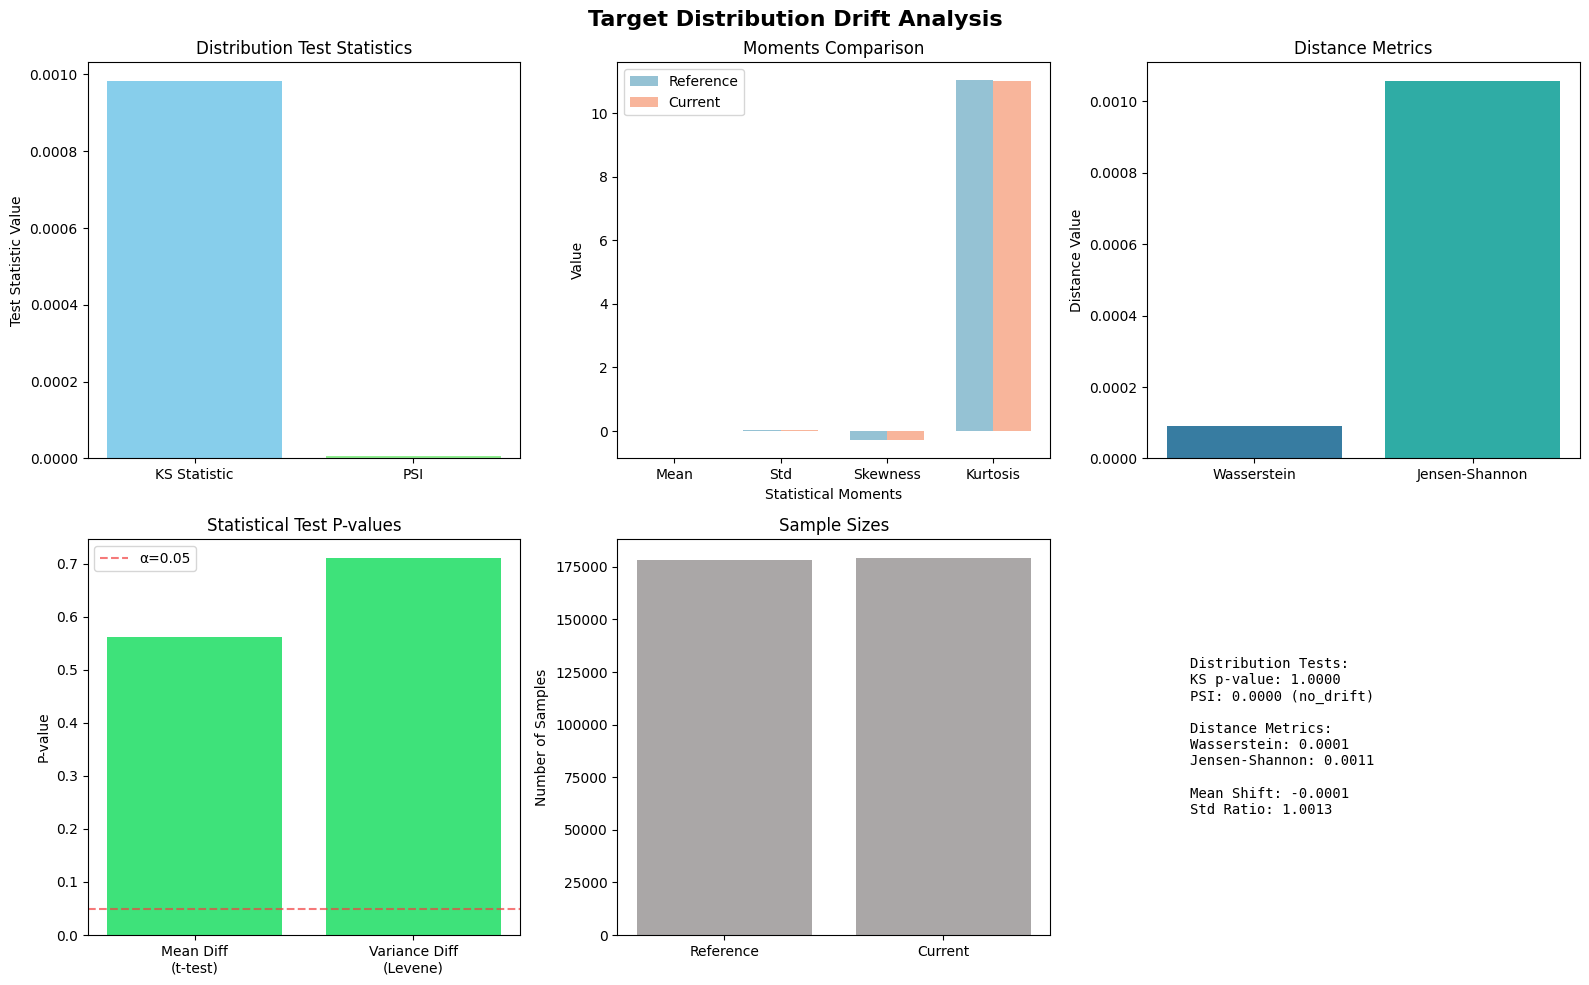

In [10]:
# Visualize target drift
plot_drift_metrics(target_drift_results, figsize=(16, 10))

### 4. Model Performance Monitoring

In [11]:
# Generate predictions for both reference and current data
print("Generating model predictions...")

# Reference predictions (test set)
ref_X = reference_data.drop(columns=[target_col])
ref_y = reference_data[target_col]

ref_transformed = model.named_steps["transformations"].transform(ref_X)
ref_predictions = model.named_steps["model"].predict(ref_transformed, return_full_quantiles=True)

print(f"Reference predictions shape: {ref_predictions.shape}")

# Current predictions
curr_X = current_data.drop(columns=[target_col, 'date'])
curr_y = current_data[target_col]

curr_transformed = model.named_steps["transformations"].transform(curr_X)
curr_predictions = model.named_steps["model"].predict(curr_transformed, return_full_quantiles=True)

print(f"Current predictions shape: {curr_predictions.shape}")

print(f"Model quantiles: {config.modeling.quantiles}")
print(f"Prediction output: {ref_predictions.shape[1]} quantiles per sample")

Generating model predictions...
Reference predictions shape: (178325, 5)
Current predictions shape: (179230, 5)
Model quantiles: [0.1, 0.25, 0.5, 0.75, 0.9]
Prediction output: 5 quantiles per sample


In [12]:
# Evaluate quantile regression performance on current data
quantile_cols = [f'q_{q:.2f}' for q in config.modeling.quantiles]
curr_pred_df = pd.DataFrame(curr_predictions, columns=quantile_cols)

current_performance = get_predicted_quantiles_metrics(
    y_true=curr_y,
    y_pred_quantiles=curr_pred_df,
    quantiles=config.modeling.quantiles
)

print("=== CURRENT MODEL PERFORMANCE ===")
print(f"Mean Pinball Loss: {current_performance['pinball_losses']['mean']:.6f}")
print(f"CRPS: {current_performance['distributional']['crps']:.6f}")
print(f"Coverage Bias: {current_performance['coverage']['bias']:.6f}")
print(f"Mean Coverage Error: {current_performance['coverage']['mean_absolute_error']:.6f}")
print(f"Monotonicity Violation Rate: {current_performance['monotonicity']['violation_rate']:.4%}")

print(f"\n=== PER-QUANTILE PERFORMANCE ===")
for q in config.modeling.quantiles:
    q_key = f'q_{q:.2f}'
    pinball = current_performance['pinball_losses']['per_quantile'][q_key]
    coverage = current_performance['coverage']['per_quantile'][q_key]
    coverage_err = current_performance['coverage']['errors'][q_key]
    print(f"Q{q:.2f}: Pinball={pinball:.6f} | Coverage={coverage:.3f} (target={q:.2f}) | Error={coverage_err:+.3f}")

=== CURRENT MODEL PERFORMANCE ===
Mean Pinball Loss: 0.011247
CRPS: 0.020100
Coverage Bias: -0.009956
Mean Coverage Error: 0.010960
Monotonicity Violation Rate: 0.0000%

=== PER-QUANTILE PERFORMANCE ===
Q0.10: Pinball=0.008546 | Coverage=0.102 (target=0.10) | Error=+0.002
Q0.25: Pinball=0.013296 | Coverage=0.229 (target=0.25) | Error=-0.021
Q0.50: Pinball=0.015219 | Coverage=0.474 (target=0.50) | Error=-0.026
Q0.75: Pinball=0.012055 | Coverage=0.745 (target=0.75) | Error=-0.005
Q0.90: Pinball=0.007119 | Coverage=0.900 (target=0.90) | Error=+0.000


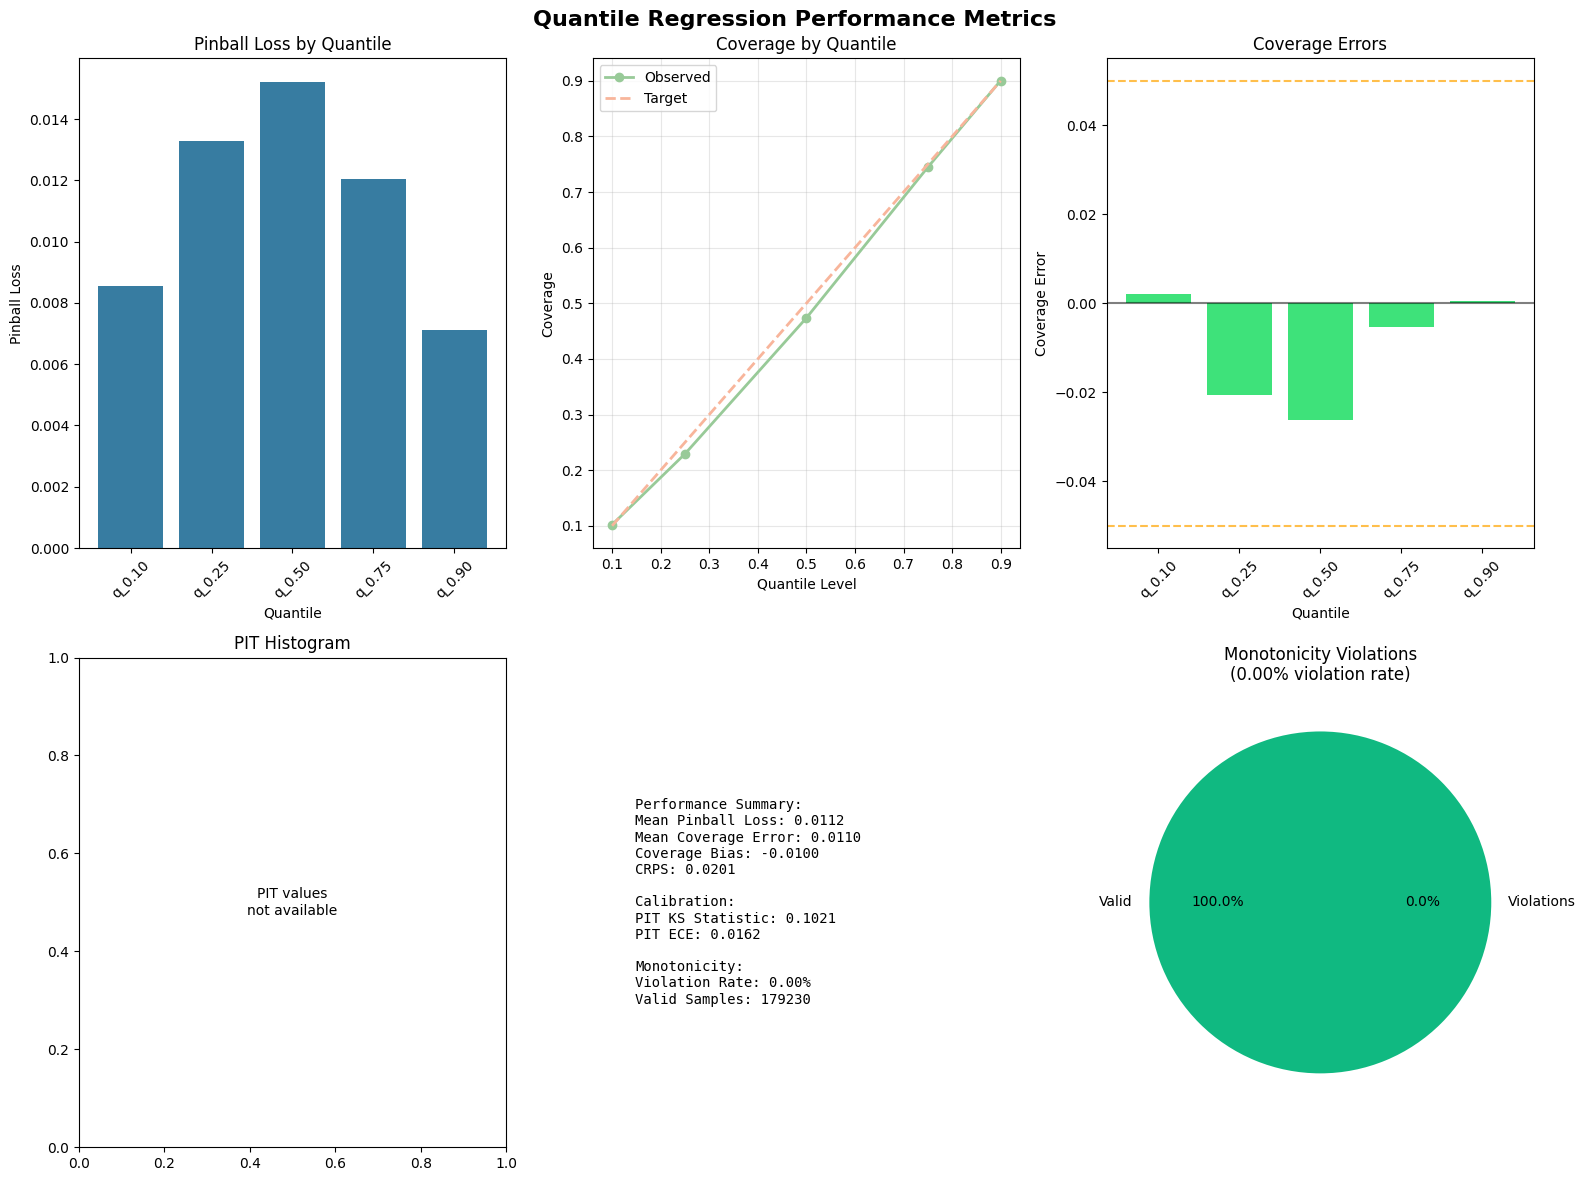

In [13]:
# Visualize quantile regression performance
plot_performance_metrics(current_performance, figsize=(16, 12))

### 5. Prediction Drift Detection

In [14]:
# Analyze prediction drift between reference and current periods
ref_pred_df = pd.DataFrame(ref_predictions, columns=quantile_cols)

prediction_drift_results = get_prediction_drift_metrics(
    reference_predictions=ref_pred_df,
    current_predictions=curr_pred_df,
    quantiles=config.modeling.quantiles
)

print("=== PREDICTION DRIFT ANALYSIS ===")
agg_pred = prediction_drift_results["aggregate"]
print(f"Mean KS Statistic: {agg_pred['mean_ks_statistic']:.4f}")
print(f"Max KS Statistic: {agg_pred['max_ks_statistic']:.4f}")
print(f"Mean Wasserstein Distance: {agg_pred['mean_wasserstein']:.6f}")
print(f"Max Wasserstein Distance: {agg_pred['max_wasserstein']:.6f}")

print(f"\n=== PER-QUANTILE PREDICTION DRIFT ===")
per_quantile_pred = prediction_drift_results["per_quantile"]
for q in config.modeling.quantiles:
    q_key = f'q_{q:.2f}'
    metrics = per_quantile_pred[q_key]
    print(f"Q{q:.2f}: KS={metrics['ks_statistic']:.4f} (p={metrics['ks_p_value']:.4f}) | "
          f"PSI={metrics['psi']:.4f} ({metrics['psi_interpretation']}) | "
          f"Wasserstein={metrics['wasserstein_distance']:.6f}")

=== PREDICTION DRIFT ANALYSIS ===
Mean KS Statistic: 0.0014
Max KS Statistic: 0.0020
Mean Wasserstein Distance: 0.000016
Max Wasserstein Distance: 0.000029

=== PER-QUANTILE PREDICTION DRIFT ===
Q0.10: KS=0.0015 (p=0.9830) | PSI=0.0000 (no_drift) | Wasserstein=0.000029
Q0.25: KS=0.0017 (p=0.9519) | PSI=0.0000 (no_drift) | Wasserstein=0.000018
Q0.50: KS=0.0020 (p=0.8646) | PSI=0.0000 (no_drift) | Wasserstein=0.000007
Q0.75: KS=0.0007 (p=1.0000) | PSI=0.0000 (no_drift) | Wasserstein=0.000007
Q0.90: KS=0.0009 (p=1.0000) | PSI=0.0000 (no_drift) | Wasserstein=0.000018


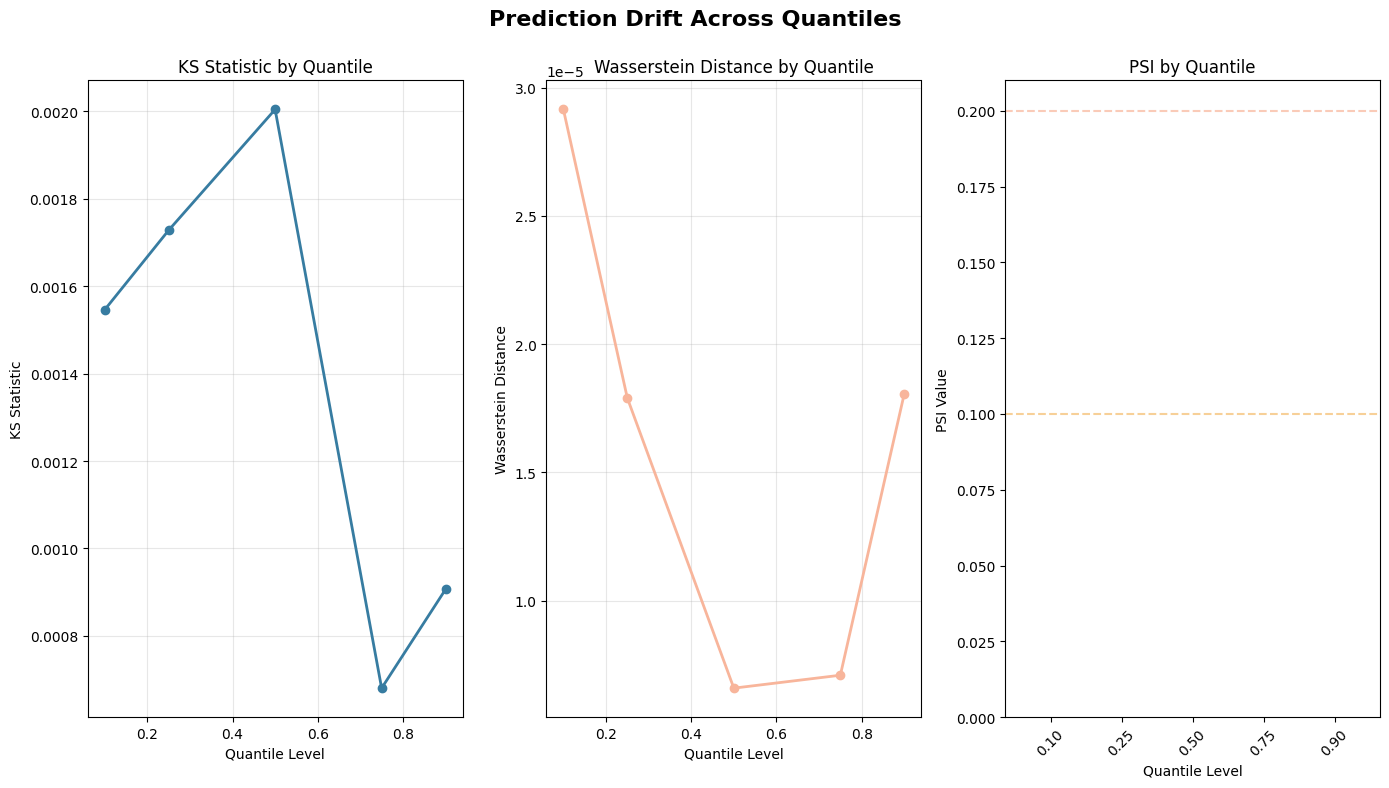

In [15]:
# Visualize prediction drift
plot_drift_metrics(prediction_drift_results, figsize=(14, 8))

### 6. Prediction Interval Calibration Analysis

In [16]:
# Analyze prediction interval calibration (using 80% intervals)
target_coverage = config.modeling.target_coverage
alpha = 1 - target_coverage

# Extract prediction intervals (lower and upper bounds)
# Assuming the model outputs calibrated intervals as lower/upper bounds
# If not, we'd need to extract specific quantiles (e.g., 0.1 and 0.9 for 80% interval)

# For 80% coverage, we typically use 0.1 and 0.9 quantiles
lower_quantile = alpha / 2  # 0.1 for 80% interval
upper_quantile = 1 - alpha / 2  # 0.9 for 80% interval

# Find the closest quantiles in our model output
quantiles_array = np.array(config.modeling.quantiles)
lower_idx = np.argmin(np.abs(quantiles_array - lower_quantile))
upper_idx = np.argmin(np.abs(quantiles_array - upper_quantile))

print(f"Target coverage: {target_coverage:.1%}")
print(f"Using quantiles: {config.modeling.quantiles[lower_idx]:.2f} (lower) and {config.modeling.quantiles[upper_idx]:.2f} (upper)")

# Extract intervals from current predictions
curr_predictions = model.predict(curr_X)
ref_predictions = model.predict(ref_X)

y_lower = curr_predictions[:, 0]
y_upper = curr_predictions[:, -1]

calibration_results = get_calibration_metrics(
    y_true=curr_y,
    y_lower=pd.Series(y_lower),
    y_upper=pd.Series(y_upper),
    confidence_level=target_coverage
)

print(f"\n=== PREDICTION INTERVAL PERFORMANCE ===")
coverage_info = calibration_results["coverage"]
print(f"Observed Coverage: {coverage_info['observed']:.3f}")
print(f"Target Coverage: {coverage_info['target']:.3f}")
print(f"Coverage Error: {coverage_info['error']:.3f}")
print(f"Below Lower Rate: {coverage_info['below_lower_rate']:.3f}")
print(f"Above Upper Rate: {coverage_info['above_upper_rate']:.3f}")

width_info = calibration_results["interval_width"]
print(f"\nMean Interval Width: {width_info['mean_width']:.6f}")
print(f"Normalized Width: {width_info['normalized_width']:.4f}")

scoring_info = calibration_results["scoring"]
print(f"\nInterval Score: {scoring_info['interval_score']:.6f}")
print(f"Efficiency Ratio: {scoring_info['efficiency_ratio']:.4f}")

Target coverage: 80.0%
Using quantiles: 0.10 (lower) and 0.90 (upper)



=== PREDICTION INTERVAL PERFORMANCE ===
Observed Coverage: 0.753
Target Coverage: 0.800
Coverage Error: -0.047
Below Lower Rate: 0.125
Above Upper Rate: 0.121

Mean Interval Width: 0.078437
Normalized Width: 1.6835

Interval Score: 0.168843
Efficiency Ratio: 0.4474


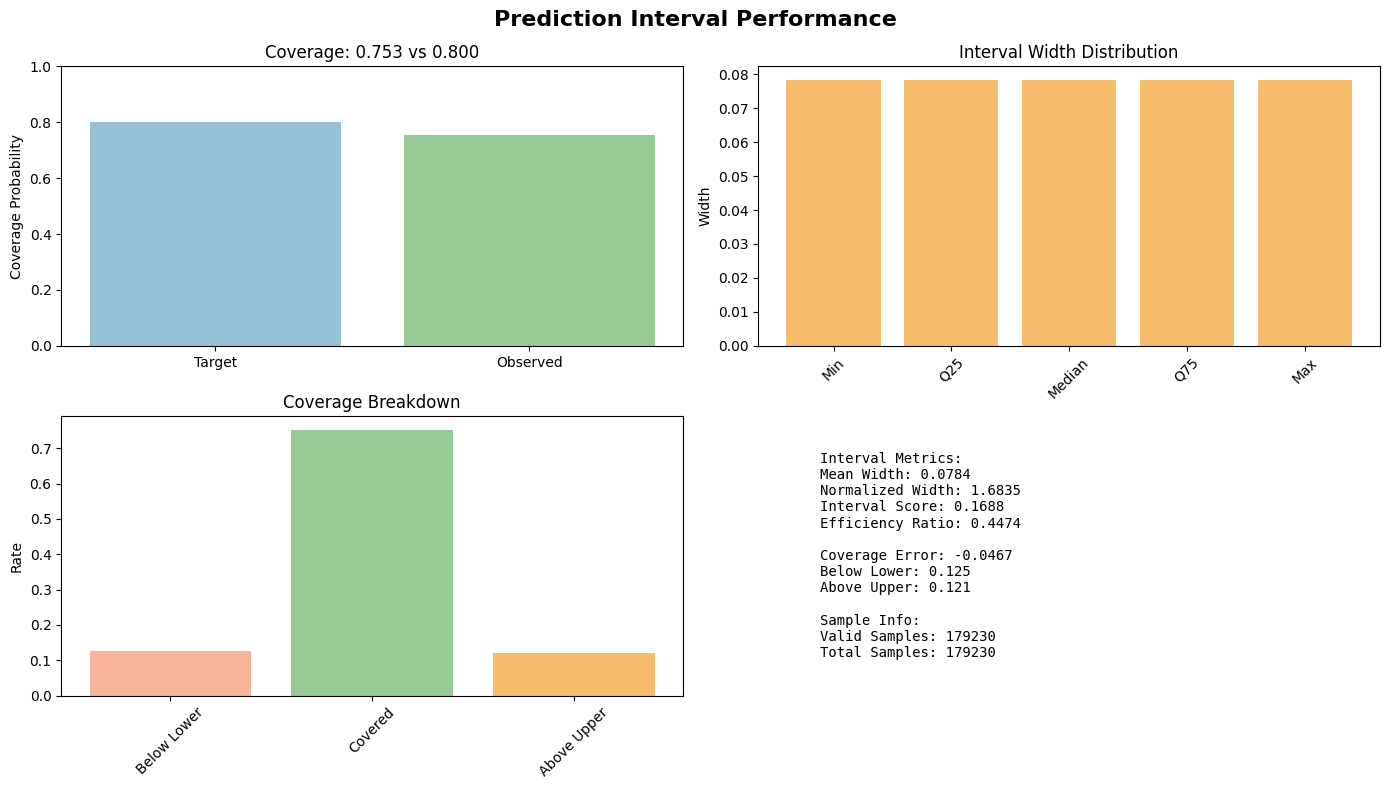

In [17]:
# Visualize calibration performance
plot_performance_metrics(calibration_results, figsize=(14, 8))

### 7. Comprehensive Monitoring Report

In [18]:
# Generate comprehensive monitoring report
monitoring_results = {
    "drift_results": {
        "covariate_drift": covariate_drift_results,
        "target_drift": target_drift_results,
        "prediction_drift": prediction_drift_results
    },
    "performance_results": {
        "quantile_performance": current_performance,
        "calibration_performance": calibration_results
    }
}

# Generate HTML report
report_path = "monitoring_report.html"
html_report = generate_monitoring_report(
    monitoring_results=monitoring_results,
    title="Stock Market Analytics - Model Monitoring Report"
)

print(f"\n=== MONITORING SUMMARY ===")
print(f"✅ Covariate drift analysis: {len(drift_features)} features analyzed")
print(f"✅ Target drift analysis: Distribution comparison completed")
print(f"✅ Prediction drift analysis: {len(config.modeling.quantiles)} quantiles analyzed") 
print(f"✅ Model performance: Quantile regression metrics calculated")
print(f"✅ Calibration analysis: {target_coverage:.0%} prediction intervals evaluated")
print(f"✅ HTML report generated: {report_path}")

print(f"\n=== KEY FINDINGS ===")
print(f"• Mean PSI (covariate drift): {covariate_drift_results['aggregate']['mean_psi']:.4f}")
print(f"• Target PSI: {target_drift_results['distribution_tests']['psi']:.4f} ({target_drift_results['distribution_tests']['psi_interpretation']})")
print(f"• Mean prediction drift (KS): {prediction_drift_results['aggregate']['mean_ks_statistic']:.4f}")
print(f"• Model performance (CRPS): {current_performance['distributional']['crps']:.6f}")
print(f"• Coverage error: {calibration_results['coverage']['error']:.3f} (target: {target_coverage:.1%})")
print(f"• Monotonicity violations: {current_performance['monotonicity']['violation_rate']:.2%}")


=== MONITORING SUMMARY ===
✅ Covariate drift analysis: 48 features analyzed
✅ Target drift analysis: Distribution comparison completed
✅ Prediction drift analysis: 5 quantiles analyzed
✅ Model performance: Quantile regression metrics calculated
✅ Calibration analysis: 80% prediction intervals evaluated
✅ HTML report generated: monitoring_report.html

=== KEY FINDINGS ===
• Mean PSI (covariate drift): 0.0000
• Target PSI: 0.0000 (no_drift)
• Mean prediction drift (KS): 0.0014
• Model performance (CRPS): 0.020100
• Coverage error: -0.047 (target: 80.0%)
• Monotonicity violations: 0.00%
